In [61]:
%pip install gym

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
import random
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.signal import fftconvolve

seed = 6
np.random.seed(seed)
random.seed(seed)
matplotlib.rc('animation', html='jshtml')

# Környezet

A környezet a frozen lake v1-es környezete. A feladatban 8x8-as térkép volt írva, viszont akkora térkép mellett, nem voltam képes elég nagy számú iterációt lefuttatni a tanuláshoz, úgy, hogy magas hatásfokkal tudja megtanulni a környezetet az algoritmus. Minél nagyobb a térkép, anál több iteráció szükséges a tanuláshoz. Ha maximalizáljuk a lépések számát egy epizódban, akkor meg kell fontolnunk a max lépésszám növelését is, mivel kisebb az esélye a kincs megszerzésére. Pontot csak akkor ad környezet, ha elérjük a kincset. Ha bármely más mezőre lépünk, jég vagy vízbe, akkor 0 jutalmat kapunk.   

In [63]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array')
action_mapping = {
    0: "←",
    1: "↓",
    2: "→",
    3: "↑"
}

A = list(action_mapping.keys())

# Diagramok

In [64]:
def plot_v_means(v_means):
    plt.figure(figsize=(5, 5))
    plt.plot(v_means)
    plt.legend(loc='lower right')
    plt.xlabel('Időlépés')
    plt.ylabel('$V(s)$')
    plt.show()

In [65]:
def plot_compare_values(mc_values, td_values):
    plt.figure(figsize=(5, 5))
    plt.plot(mc_values, label='mc')
    plt.plot(td_values, label='td')
    plt.legend()
    plt.show()

In [66]:
def plot_r_mean(r_track):
    def window_avg(lst, window_size):
        window_size = int(window_size)
        kernel = np.ones(window_size) / window_size
        return fftconvolve(lst, kernel, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.title('Epizódonkénti jutalom (mozgóátlagolással)')
    plt.plot(window_avg(r_track, len(r_track) / 200))
    plt.ylabel('Átlagos jutalom')
    plt.xlabel('Iteráció')
    plt.show()

# Animáció
Az animáció során egy teljes epizódon megyünk végig a már optimalizált politika segítségével. Tapasztalat: Nagyon rossz politikával képes volt 32 GB memóriát telepakolni.

In [67]:
def show_animation(env, policy):
    def update_scene(num, frames, patch):
        patch.set_data(frames[num])
        return patch

    def plot_animation(frames, repeat=True, interval=40):
        fig = plt.figure()
        patch = plt.imshow(frames[0])
        plt.axis('off')
        anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat,
                                       interval=interval)
        plt.close()
        return anim

    frames = []
    done = False
    s = env.reset(seed=seed)[0]

    while not done:
        a = policy[s]
        sp, _, done, _, _ = env.step(a)
        frames.append(env.render())
        if done:
            break
        s = sp

    return plot_animation(frames, True, 100)

# Monte Carlo

In [68]:
mc_policy = {s: np.random.choice(A) for s in range(env.observation_space.n)}
mc_max_i = 100
mc_learn_max_i = 10000
mc_gamma = 0.98

In [69]:
def get_action(policy, s, eps):
    p = np.random.random()
    if p < eps:
        return np.random.choice(A)
    return policy[s]

A követkető epizód generáló metódusban addig visszünk egy epizódott, ameddig vagy meg nem szerzi a kincset, vagy meg nem hal a hobbitunk. A lépések során az új állapotot, a választott mozgást és a kapott jutalmat egy-egy listában eltároljuk. Így az epizódot mozgásonként ki tudjuk értékelni.

In [70]:
def generate_mc_episode(mc_env, s, policy, eps):
    states = []
    actions = []
    rewards = []
    done = False

    while not done:
        a = get_action(policy, s, eps)
        sp, r, done, _, _ = mc_env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = sp
        
    return states, actions, rewards

In [71]:
def mc_eval(env, policy, max_i, gamma):
    v = [np.random.random() for _ in range(env.observation_space.n)]
    hozam = [[] for _ in range(env.observation_space.n)]

    for i in range(max_i):
        s0 = env.reset(seed=seed)[0]
        states, actions, rewards = generate_mc_episode(env, s0, policy, 0)
        g = 0

        for t in range(len(states) - 2, 0, -1):
            g = gamma * g + rewards[t + 1]
            if (states[t], actions[t]) not in list(zip(states, actions))[0:t - 1]:
                hozam[states[t]].append(g)
                v[states[t]] = np.mean(hozam[states[t]])

    return v

In [72]:
Q = np.random.random(size=(env.observation_space.n, env.action_space.n))
Q[env.observation_space.n - 1, :] = 0
Hozam = [[[] for _ in range(env.action_space.n)] for _ in range(env.observation_space.n)]
eps_end = 0
eps_decay = 0.999
eps_start = 0.99
eps = eps_start
V_tracks = []
V_means = []
R_tracks = []
R_means = []

for i in range(mc_learn_max_i):
    s0 = env.reset(seed=seed)[0]
    states, actions, rewards = generate_mc_episode(env, s0, mc_policy, eps)
    G = 0

    for t in range(len(states) - 2, 0, -1):
        G = mc_gamma * G + rewards[t + 1]

        if (states[t], actions[t]) not in list(zip(states, actions))[0:t - 1]:
            Hozam[states[t]][actions[t]].append(G)
            Q[states[t]][actions[t]] = np.mean(Hozam[states[t]][actions[t]])
            mc_policy[states[t]] = np.argmax(Q[states[t]])

    eps = eps * eps_decay if eps > eps_end else eps_end
    V = mc_eval(env, mc_policy, mc_max_i, mc_gamma)
    V_tracks.append(V)
    V_means.append(np.mean(np.array(V_tracks), axis=0))
    R_tracks.append(sum(rewards))
    R_means.append(np.mean(R_tracks))

In [73]:
mc_values = mc_eval(env, mc_policy, mc_max_i, mc_gamma)

In [74]:
show_animation(env, mc_policy)

Az alábbi diagramon az várható jutalmak átlagának változását lehet látni ha egyes állapotokból indulunk ki, az interációk mennyiségének függvényében. Egyes állapotok jövedelmezőbben a többinél, de elmondható, hogy az állapotok nagy többségéből indulva megegyeznek a várható jutalmak értéke.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


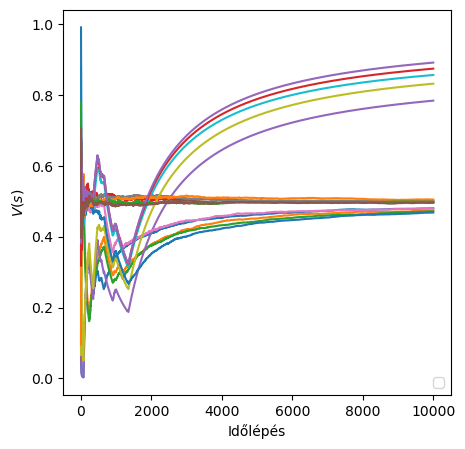

In [75]:
plot_v_means(V_means)

Az alábbi diagramon jól látszik, hogy az epizódonkénti jutalomak száma az iterációk során nőtt, ezáltal kijelenthető, hogy az algoritmus képes volt tanulni. 

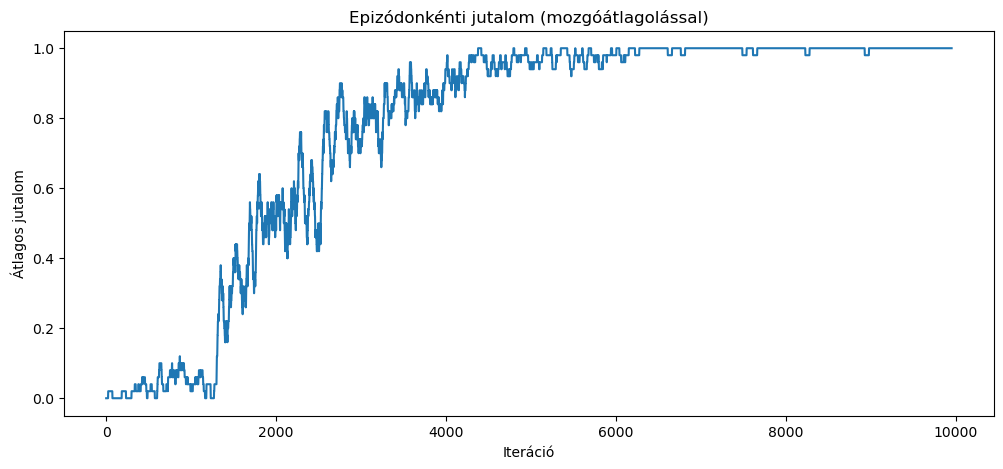

In [76]:
plot_r_mean(R_tracks)

In [77]:
def td_eval(env: gym.Env, policy, max_i: int, gamma: float, alpha: float):
    V = [np.random.random() for _ in range(env.observation_space.n)]
    V[env.observation_space.n - 1] = 0

    for _ in range(max_i):
        s = env.reset(seed=seed)[0]
        done = False

        for _ in range(max_i):
            a = get_action(policy, s, 0)
            sp, r, done, _, _ = env.step(a)
            V[s] = V[s] + alpha * (r + gamma * V[sp] - V[s])
            s = sp
            if done:
                break

    return V

In [78]:
td_max_i = 100
td_learn_max_i = 10000
td_gamma = 0.98
td_alpha = 0.1
td_policy = {s: np.random.choice(A) for s in range(env.observation_space.n)}
td_policy[env.observation_space.n - 1] = 0
Q = np.random.random(size=(env.observation_space.n, env.action_space.n))
Q[env.observation_space.n - 1, : ] = 0
eps_end = 0
eps_decay = 0.9999
eps_start = 0.99
eps = eps_start
V_tracks = []
V_means = []
R_tracks = []
R_means = []

for i in range(td_learn_max_i):
    s = env.reset(seed=seed)[0]
    a = get_action(td_policy, s, eps)
    r_sum = 0
    done = False

    for _ in range(td_max_i):
        if done:
            break
        sp, r, done, _, _ = env.step(a)
        ap = get_action(td_policy, s, eps)
        Q[s][a] = Q[s][a] + td_alpha * (r + td_gamma * Q[sp][ap] - Q[s][a])
        td_policy[s] = np.argmax(Q[s])
        r_sum += r
        s = sp
        a = ap
    
    eps = eps * eps_decay if eps > eps_end else eps_end
    V = td_eval(env, td_policy, td_max_i, td_gamma, td_alpha)
    V_tracks.append(V)
    V_means.append(np.mean(np.array(V_tracks), axis=0))
    R_tracks.append(r_sum)
    R_means.append(np.mean(np.array(R_tracks), axis=0))


In [79]:
show_animation(env, td_policy)

Elnondható, hogy bármely állapotból kiindulva közel azonos a várható átlagos jutalom.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


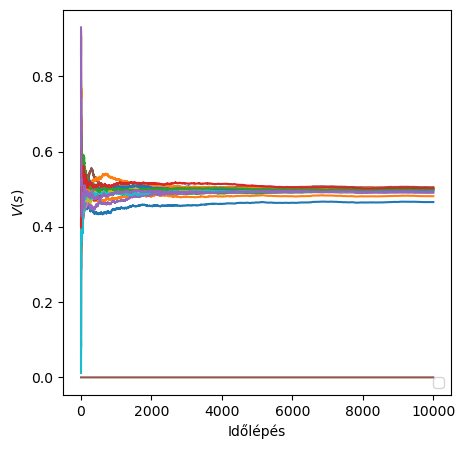

In [80]:
plot_v_means(V_means)

In [81]:
td_values = td_eval(env, td_policy, td_max_i, td_gamma, td_alpha)

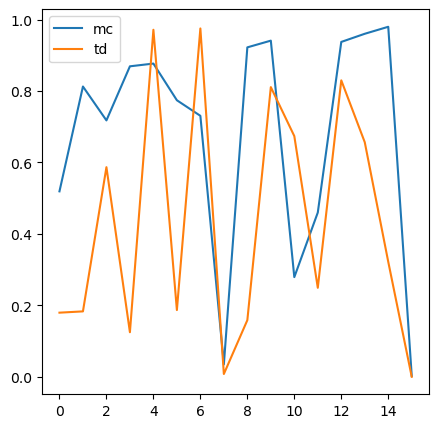

In [82]:
plot_compare_values(mc_values, td_values)

A TD algoritmus politikáját nem sikerült 10000 iteráció alatt olyan szinten betanítani, mint az előző Monte Carlo algoritmus politikáját. Habár reményre adhat okot, hogy ahogy az iterációk előrehaladtával az epszilon érték csökkent, s ezzel egyre-egyre kevésbé fedezett fel, az epizódonkénti átlagos jutalom mértéke nem csökkent. Hosszabb magas felfedezési fázissal és több iterációval jobban optimalizálható lett volna a plitika. 

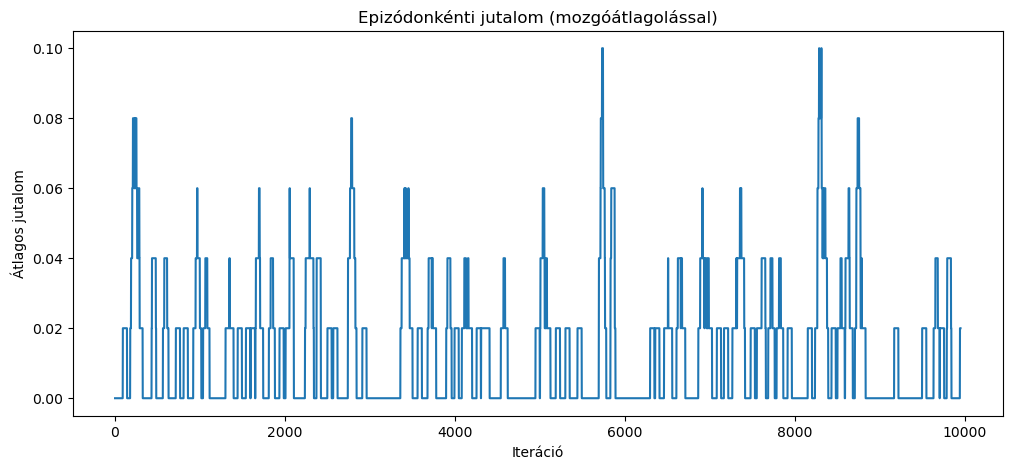

In [83]:
plot_r_mean(R_tracks)

A TD algoritmus esetén, az úgy nevezett SARSA variánst használtam, amely a Monte Carlohoz hasonlóan, politika vezérelt. A tanulás során ezt a politikát optimalizálják.
Sajnos nem sikerült a TD politikát megfelelően optimalizálni, így nem vagyok képes a két algoritmus pontos összehasonlítására. Habár a munka során nagyon sokat tapasztaltam, így azokra támaszkodva a következő következtetéseket tudom tenni. 
Mindkét algoritmus tanulási folyamata egy véletlenszerű politikából indult ki, amelyet az iterációk során optimalizált az epizódból szerzett tapasztalat alapján. Mivel a kezdeti politika véletlenszerű volt, így szükséges volt az algoritmusoknak felfedezni.
A felfedezés abból állt, hogy az iterációk haladtával egyre csökkenő valószínűségben választott random mozgást. Ezáltal a tanulási folyamat elején a többlet tapasztalatot felhasználva képes volt olyan mértékben javítani a politikán, hogy nagyon hamar nagy valószínűségben a saját politikát felhasználva tudott jutalmat szerezni. Ezt hívját epszilon párologtatásnak.
A felfedezés valószínűségének csökkennésének mértékének megválasztása során érdemes figyelembe venni a maximum tanulási iterációk számát, hogy biztosan lássuk, hogy csak a saját politika felhasználásával is képes a jutalmak nagymennyiségű megszerzésére.
A Monte Carlo algoritmusnak kevesebb iterációra van szüksége az optimális politika kialakítására.
Előnye a TD algoritmusnak, a Monte Carlo-hoz képest, hogy itt nem szükséges egy epizód teljes lejátszására.
Mindkét algoritmus tanulása során használunk egy úgynevezett Q táblát. A Q tábla állapot-cselekvés párokhoz tartozó várható jutalom mértékét tárolja, azaz megmondható általa, hogy egy adott állapotban, egy adott cselekvést választva mekkora jutalmat várhatunk egy adott politika mellett. A tanulási folyamatban a megserzett tapasztalat által frissítjük a mátrix megfelelő értékét, majd az adott állapothoz tartozó várható jutalmak maximumának megszerzéséhez szükséges cselekvés értékét állítjuk be a politika adott állapotához. 
A TD algoritmusnál a Q tábla értékét a Q tábla régi és új állapot-cselekvés értéke alapján számoljuk ki.
A Monte Carlo algoritmusnál a Q tábla értékét az epizód hozamainak átlagaként számoljuk ki. 
